# Imports & random seed


In [46]:
# !pip install qiskit
# !pip install qiskit_aer
# !pip install qiskit_algorithms
# !pip install pylatexenc
# !pip install qiskit_ibm_runtime
# !pip install qiskit_nature qiskit qiskit.algorithms qiskit_aer
# !pip install pyscf


In [47]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter
from qiskit_aer.primitives import Sampler, Estimator
from qiskit_algorithms.optimizers import SLSQP, SPSA
import pylatexenc
from qiskit_ibm_runtime.fake_provider import FakeKolkata
from qiskit.circuit.library import EfficientSU2
import numpy as np
import qiskit_nature
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
from qiskit_aer.primitives import Estimator
from qiskit_aer.noise import NoiseModel
from qiskit_algorithms.optimizers import SLSQP, SPSA, COBYLA
from qiskit_aer.noise import NoiseModel


np.random.seed(999999)

# Used functions

In [48]:
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name="c")
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

In [49]:
def get_qubit_op(molecule):
    '''
    Uses ParityMapper
    '''
    driver = PySCFDriver.from_molecule(molecule)
    properties = driver.run()
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    # mapper = JordanWignerMapper()
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [50]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

# Class MoleculeManager

In [51]:
class MoleculeManager():
  '''
  MoleculeManager\n

  '''
  def __init__(
      self,
      molecule: MoleculeInfo,
      optimizer=COBYLA(maxiter=500, tol=0.0001),

  ):
    self.molecule = molecule
    self.optimizer = optimizer


  def SetDualAtomDist(self, dist: float):
    '''
    Sets a distance between atoms of a molecule of two atoms
    '''
    self.molecule.coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0])


  def SetAtomCoords(self, coords):
    '''
    Sets a distance between atoms of a molecule of two atoms
    '''
    self.molecule.coords = coords


  def print_interatomic_distance(self):
    print(f"Interatomic Distance:")
    for atom1_idx in range(len(self.molecule.coords) - 1):
      for atom2_idx in range(atom1_idx + 1, len(self.molecule.coords)):
        print('|', self.molecule.symbols[atom1_idx],', ', self.molecule.symbols[atom2_idx],'| = ', round(np.linalg.norm([self.molecule.coords[atom1_idx],self.molecule.coords[atom2_idx]]), 5))



  def FindEnergyIdeal(self, print_energy=True, print_ansatz=True, print_circuit_info=True):
    '''
    returns vqe_result -- ground state energy value (float)
    '''

    exact_energies = []
    vqe_energies = []
    optimizer = SLSQP(maxiter=10)
    noiseless_estimator = Estimator(approximation=True)
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(self.molecule)

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    ansatz = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        ansatz,
        optimizer,
        initial_point=[0] * ansatz.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    
    if (print_ansatz):
      display(ansatz.decompose().decompose().draw(fold=-1))
    if (print_circuit_info):
      print(f'ansatz.depth = {ansatz.depth()}')
      print(f'num of qubits = {ansatz.num_qubits}')
    if (print_energy):
      print(result)
      print(
          f"### TODO! what's the difference between VQE Result and Exact energy?\n",
          f"VQE Result: {vqe_result:.5f}\n",
          f"Exact Energy: {exact_energies[-1]:.5f}\n",
      )
      self.print_interatomic_distance()    
    return vqe_result


  def FindEnergyNoisy(self):
    exact_energies = []
    vqe_energies = []
    device = FakeKolkata()
    coupling_map = device.configuration().coupling_map
    noise_model = NoiseModel.from_backend(device)
    noisy_estimator = Estimator(
        backend_options={"coupling_map": coupling_map, "noise_model": noise_model}
    )
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(self.molecule)
    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies)

    print("Exact Result:", result.total_energies)
    optimizer = SPSA(maxiter=100)
    var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
    vqe = VQE(noisy_estimator, var_form, optimizer)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies
    print("VQE Result:", vqe_result)


LiH + H2O <-> LiOH + H2 

In [52]:
dist = 1
LiH_info = MoleculeInfo(
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
LiH = MoleculeManager(molecule=LiH_info)

# angle: 104 deg.
# structure: H - O - H
hho_deg = 104
hho_info = MoleculeInfo(
        symbols=["H", "O", "H"],
        coords=([-dist, 0.0, 0.0], [0.0, 0.0, 0.0], [dist * np.cos(np.deg2rad(180 - hho_deg)), dist * np.sin(np.deg2rad(180 - hho_deg)), 0.0]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
HHO = MoleculeManager(molecule=hho_info)


In [53]:
LiH.FindEnergyIdeal(print_ansatz=False)

ansatz.depth = 1
num of qubits = 8
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -9.371552953208
  - computed part:      -1.174236549311
  - FreezeCoreTransformer extracted energy part: -8.197316403898
~ Nuclear repulsion energy (Hartree): 1.58753163276
> Total ground state energy (Hartree): -7.784021320448
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.88972612  0.0  0.0]
 
### TODO! what's the difference between VQE Result and Exact energy?
 VQE Result: -7.78402
 Exact Energy: -7.78402

Interatomic Distance:
| Li ,  H | =  1.0


-7.7840212919055825

In [54]:
# HHO.FindEnergyIdeal(print_ansatz=False)

```
ansatz.depth = 1
num of qubits = 10
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -83.822664243954
  - computed part:      -23.255302577322
  - FreezeCoreTransformer extracted energy part: -60.567361666632
~ Nuclear repulsion energy (Hartree): 8.802603134549
> Total ground state energy (Hartree): -75.020061109405
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.43256  1.83359318  0.0]
 
### TODO! what's the difference between VQE Result and Exact energy?
 VQE Result: -75.01995
 Exact Energy: -75.02006

Interatomic Distance:
| H ,  O | =  1.0
| H ,  H | =  1.4142135623730951
| O ,  H | =  1.0000000000000002
-75.0199492799599
```

In [55]:
HHO_energy = HHO.FindEnergyIdeal(print_energy=False, print_circuit_info=False, print_ansatz=False)

## Summed energy of left handside. Geometry experiments 

### LiH experiment

In [68]:
LiH_distances = np.round(np.linspace(0.1, 10, 50), 1)
LiH_distances

array([ 0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9,  2.1,
        2.3,  2.5,  2.7,  2.9,  3.1,  3.3,  3.5,  3.7,  3.9,  4.1,  4.3,
        4.5,  4.7,  4.9,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,
        6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,
        9. ,  9.2,  9.4,  9.6,  9.8, 10. ])

In [69]:
LiH_E = []
total_E_left = []

for dist in LiH_distances:
  LiH.SetDualAtomDist(dist)
  LiH.print_interatomic_distance()
  LiH_E_tmp = LiH.FindEnergyIdeal(print_energy=False, print_circuit_info=False, print_ansatz=False)
  print(f'LiH energy == {LiH_E_tmp}')
  LiH_E.append(LiH_E_tmp)
  total_E_left.append(LiH_E_tmp + HHO_energy)
                                        

Interatomic Distance:
| Li ,  H | =  0.1
LiH energy == 2.764504872444965
Interatomic Distance:
| Li ,  H | =  0.3
LiH energy == -5.877241747508933
Interatomic Distance:
| Li ,  H | =  0.5
LiH energy == -7.047909593720682
Interatomic Distance:
| Li ,  H | =  0.7
LiH energy == -7.503999680631518
Interatomic Distance:
| Li ,  H | =  0.9
LiH energy == -7.722834554872036
Interatomic Distance:
| Li ,  H | =  1.1
LiH energy == -7.825202724007655
Interatomic Distance:
| Li ,  H | =  1.3
LiH energy == -7.868904032819081
Interatomic Distance:
| Li ,  H | =  1.5
LiH energy == -7.882139855764646
Interatomic Distance:
| Li ,  H | =  1.7
LiH energy == -7.879197780719734
Interatomic Distance:
| Li ,  H | =  1.9
LiH energy == -7.867988699049308
Interatomic Distance:
| Li ,  H | =  2.1
LiH energy == -7.853196221813301
Interatomic Distance:
| Li ,  H | =  2.3
LiH energy == -7.8377240111245
Interatomic Distance:
| Li ,  H | =  2.5
LiH energy == -7.823426837670701
Interatomic Distance:
| Li ,  H | =  2.7


## Save data to ./data

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


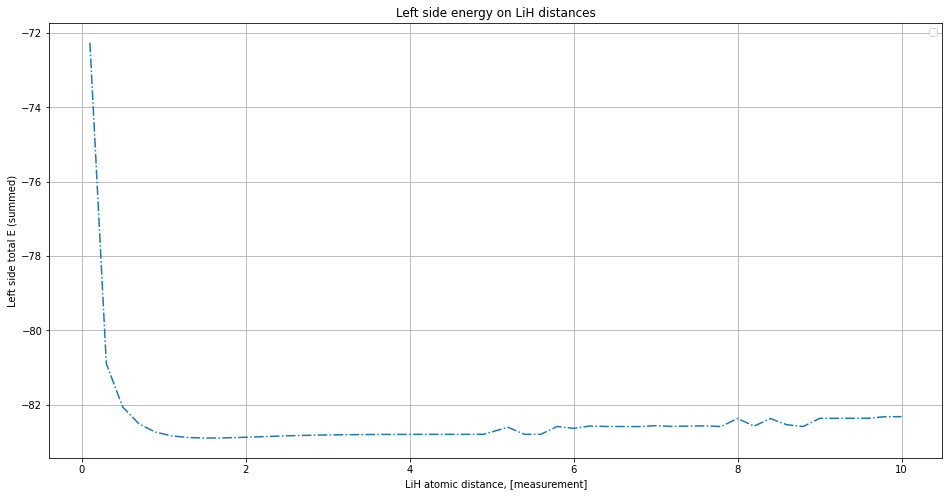

In [83]:
plt.figure(figsize=(16, 8))  
plt.plot(LiH_distances, total_E_left, linestyle='dashdot')
plt.xlabel('LiH atomic distance, [measurement]')
plt.ylabel('Left side total E (summed)')
plt.title('Left side energy on LiH distances')
plt.legend()
plt.grid()
plt.savefig('plots/LiH_distances_left.png')
plt.show()

In [88]:
LiH_distance_experiment_dataframe = pd.DataFrame({
    'distance': LiH_distances,
    'LiH_E': LiH_E,
    'left_side_E': total_E_left,
})
LiH_distance_experiment_dataframe.to_csv('./data/LiH_distance_experiment.csv')

### ${H_2O}$ experiment

In [89]:
LiH.SetDualAtomDist(1)
LiH_energy = LiH.FindEnergyIdeal(print_energy=False, print_circuit_info=False, print_ansatz=False)

In [90]:
HHO_distances = np.round(np.linspace(0.1, 10, 10), 1)
HHO_distances

array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ])

In [92]:
# HHO_E = []
# total_E_left_2 = []

# for dist in HHO_distances:
#   HHO.SetAtomCoords(([-dist, 0.0, 0.0], [0.0, 0.0, 0.0], [dist * np.cos(np.deg2rad(180 - hho_deg)), dist * np.sin(np.deg2rad(180 - hho_deg)), 0.0]))
#   HHO.print_interatomic_distance()
#   HHO_E_tmp = HHO.FindEnergyIdeal(print_energy=False, print_circuit_info=False, print_ansatz=False)
#   print(f'HHO energy == {HHO_E_tmp}')
#   HHO_E.append(HHO_E_tmp)
#   total_E_left_2.append(HHO_E_tmp + LiH_energy)
                                        

Interatomic Distance:
| H ,  O | =  0.1
| H ,  H | =  0.14142
| O ,  H | =  0.1
HHO energy == -20.475763958288155
Interatomic Distance:
| H ,  O | =  1.2
| H ,  H | =  1.69706
| O ,  H | =  1.2
HHO energy == -74.9852543182796
Interatomic Distance:
| H ,  O | =  2.3
| H ,  H | =  3.25269
| O ,  H | =  2.3
HHO energy == -74.74001988622004
Interatomic Distance:
| H ,  O | =  3.4
| H ,  H | =  4.80833
| O ,  H | =  3.4


ArpackNoConvergence: ARPACK error -1: No convergence (10241 iterations, 0/1 eigenvectors converged) [ARPACK error -14: ZNAUPD did not find any eigenvalues to sufficient accuracy.]

In [93]:
# total_E_left_2

[-28.25978525025332, -82.76927561024476, -82.5240411781852]

[-28.25978525025332, -82.76927561024476, -82.5240411781852]

In [94]:
HHO_distances = np.round(np.linspace(0.1, 3, 10), 1)
print(f'{HHO_distances = }')

HHO_E = []
total_E_left_3 = []

for dist in HHO_distances:
  HHO.SetAtomCoords(([-dist, 0.0, 0.0], [0.0, 0.0, 0.0], [dist * np.cos(np.deg2rad(180 - hho_deg)), dist * np.sin(np.deg2rad(180 - hho_deg)), 0.0]))
  HHO.print_interatomic_distance()
  HHO_E_tmp = HHO.FindEnergyIdeal(print_energy=False, print_circuit_info=False, print_ansatz=False)
  print(f'HHO energy == {HHO_E_tmp}')
  HHO_E.append(HHO_E_tmp)
  total_E_left_3.append(HHO_E_tmp + LiH_energy)
                                        

HHO_distances = array([0.1, 0.4, 0.7, 1.1, 1.4, 1.7, 2. , 2.4, 2.7, 3. ])
Interatomic Distance:
| H ,  O | =  0.1
| H ,  H | =  0.14142
| O ,  H | =  0.1
HHO energy == -20.475763957057524
Interatomic Distance:
| H ,  O | =  0.4
| H ,  H | =  0.56569
| O ,  H | =  0.4
HHO energy == -71.07056157719177
Interatomic Distance:
| H ,  O | =  0.7
| H ,  H | =  0.98995
| O ,  H | =  0.7
HHO energy == -74.64318030344964
Interatomic Distance:
| H ,  O | =  1.1
| H ,  H | =  1.55563
| O ,  H | =  1.1
HHO energy == -75.01276990946508
Interatomic Distance:
| H ,  O | =  1.4
| H ,  H | =  1.9799
| O ,  H | =  1.4
HHO energy == -74.91027318750292
Interatomic Distance:
| H ,  O | =  1.7
| H ,  H | =  2.40416
| O ,  H | =  1.7
HHO energy == -74.81262249597626
Interatomic Distance:
| H ,  O | =  2.0
| H ,  H | =  2.82843
| O ,  H | =  2.0
HHO energy == -74.75881885488421
Interatomic Distance:
| H ,  O | =  2.4
| H ,  H | =  3.39411
| O ,  H | =  2.4


### Mixed left side results